<a id='top1'></a>  [errorbar.pdf](#errorbar) <br>
<a id='top2'></a>  [cloudcorrel.pdf](#cloud) <br>
<a id='top3'></a>  [Roc Var 1](#rocvar1)        <br>
<a id='top3'></a>  [Roc Var 2](#rocvar2)       <br>
<a id='top4'></a>  [Dnet](#dnet)             <br>
<a id='top5'></a>  [get_scores](#scores)       <br>

In [91]:
pwd

'/Users/nj/Documents/notebooks/results/margin-consistency-submission/notebooks'

In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
#@title imports
import os
from tqdm.notebook import tqdm as tqdm
import random
import math
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from torchmetrics.regression import KLDivergence
import scipy
from scipy import interpolate
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# to ignore the warnings
from warnings import filterwarnings
import dcor
from sklearn.feature_selection import mutual_info_regression
from astropy.table import Table
from sklearn.metrics import auc as calc_auc, det_curve
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score as calc_auroc
from sklearn.model_selection import train_test_split
import sklearn
from itertools import combinations
import plotly.express as px

In [94]:
from robustbench.utils import load_model, clean_accuracy

In [95]:
from scoreslib import *
from modeling import *
from nbutils import *

In [96]:
transform = transforms.Compose([transforms.ToTensor(),])
dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)

valid_size = 5000
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-valid_size, valid_size])
##TRAIN
dts = train_set.dataset.data[train_set.indices]
train_original= torch.stack([transform(img) for img in dts])
train_targets = torch.tensor(train_set.dataset.targets, dtype=torch.int64)[train_set.indices]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=2)
##VAL
dts = val_set.dataset.data[val_set.indices]
val_original= torch.stack([transform(img) for img in dts])
val_targets = torch.tensor(val_set.dataset.targets, dtype=torch.int64)[val_set.indices]
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128,
                                          shuffle=False, num_workers=2)
##TEST
test_set = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                download=True, transform=transform)
original= torch.stack([transform(img) for img in test_set.data])
targets = torch.tensor(test_set.targets, dtype=torch.int64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
model='Addepalli2021Towards_RN18'
path = get_path(model)
# adversarial = torch.load(path+"/fab_adverserialevm512.pt", map_location='cpu')
print(path)

../xps/cifar10/Addepalli2021Towards_RN18_Linf


In [98]:
gf = get_filenames_in_folder('../xps/cifar10')
gf.sort()#[0][:-5]
len(gf),gf

(2, ['Addepalli2021Towards_RN18_Linf', 'Ding2020MMA_Linf'])

In [99]:
tmpmodels=[x for x in get_filenames_in_folder('../xps/cifar10')]
models=[x[:-5] for x in tmpmodels]
pseudos =[getps(model) for model in models]
print(list(zip(models, pseudos)))

[('Addepalli2021Towards_RN18', 'Addepalli2021'), ('Ding2020MMA', 'Ding2020MMA')]


In [100]:
tablinf = Table.read('./textables/zoolinf.tex').to_pandas()
tablinf['Clean accuracy'] = tablinf['Clean accuracy'].map(lambda x: float(x.split('\%')[0]))
tablinf['Robust accuracy'] = tablinf['Robust accuracy'].map(lambda x: float(x.split('\%')[0]))
tablinf['Model ID'] = tablinf['Model ID'].map(lambda x: x.replace("\\",""))

In [101]:
clean_accuracies = dict()
robust_accuracies=dict()
architectures=dict()
for model in models:
    clean_accuracies[model]=tablinf[tablinf['Model ID']==model]\
    ['Clean accuracy'].to_numpy()[0]
    robust_accuracies[model]=tablinf[tablinf['Model ID']==model]\
    ['Robust accuracy'].to_numpy()[0]
    architectures[model] = tablinf[tablinf['Model ID']==model]['Architecture'].to_numpy()[0]

In [102]:
models=[m for m in models if robust_accuracies[m]>1]
models, len(models)

(['Addepalli2021Towards_RN18', 'Ding2020MMA'], 2)

In [111]:
# model='Addepalli2021Towards_RN18'
W21cache1 = dict()
W21cache2 = dict()
# fig, ax = plt.subplots(nrows=2, ncols=2)
for model in tqdm(models):
    W = get_fc_head_weight(model)
    W21stars1=dict()
    W21stars2=dict()
    for i, j in list(combinations(np.arange(10),2)):
        w21star1 = torch.linalg.vector_norm((W[i]-W[j]).detach(), ord=1)
        w21star2 = torch.linalg.vector_norm((W[i]-W[j]).detach(), ord=2)
        W21stars1[(i,j)] = w21star1
        W21stars2[(i,j)] = w21star2
    y = np.array([float(e) for e in list(W21stars1.values())])
    W21cache1[model]=y
    y = np.array([float(e) for e in list(W21stars2.values())])
    W21cache2[model]=y

  0%|                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]

Downloading...
From: https://drive.google.com/uc?id=19Q_rIIHXsYzxZ0WcZdqT-N2OD7MfgoZ0
To: /Users/nj/Documents/notebooks/results/margin-consistency-submission/notebooks/models/cifar10/Linf/Ding2020MMA.pt

  0%|                                                                                                                                                              | 0.00/23.4M [00:00<?, ?B/s]
  2%|███▎                                                                                                                                                  | 524k/23.4M [00:00<00:04, 4.99MB/s]
 16%|███████████████████████▎                                                                                                                             | 3.67M/23.4M [00:00<00:00, 20.1MB/s]
 25%|████████████████████████████████████▋                                                                                                                | 5.77M/23.4M [00:00<00:00, 19.7MB/s]
 49%|███████████████████████

In [112]:
# W21cache1 = dict()
# for model in tqdm(models):
#     W21cache1[model]=None

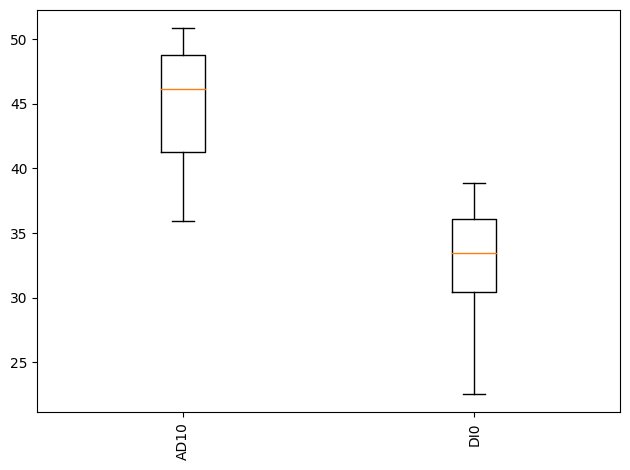

In [116]:
bp = []
for i, model in enumerate(models):
    y = W21cache1[model]
#     y = (y-min(y))/(max(y)-min(y))
    bp.append(y)
plt.boxplot(bp, showfliers=False)
# plt.set_title(getps(model, code=True, dataset='cifar10'))
names = [getps(model, code=True, dataset='cifar10') for model in models]
plt.xticks(np.arange(1, len(models)+1), names, rotation=90)
plt.tight_layout()
plt.savefig('figures/equidbox.pdf', bbox_inches='tight')
plt.show()


/Users/nj/Documents/notebooks/results/margin-consistency-submission/xps/cifar10/Ding2020MMA_Linf_New/fab_results_evm512.csv

In [117]:
dfs =dict()
ytargets=dict()
for i, model in enumerate(models):
    path1 = get_path(model)+"/fab_results_evm512.csv"
    df = pd.read_csv(path1)
    df = df.rename(str.lower, axis='columns')
#     df = df.rename(columns={f'fab norm inf': 'norm'})
    dfs[model] = df
    path1 = get_path(model)+"/fab_ytrueevm512.pt" 
    _targets = torch.load(path1)
    ytargets[model]=_targets

In [118]:
extradfs =dict()
extratargets=dict()
for i, model in enumerate(models):
    path1 = get_path(model)+"/extrafab_results_evm512.csv" #f'./fab/{models[i]}_fab/results.csv'
    if os.path.exists(path1):
        df = pd.read_csv(path1)
        df = df.rename(str.lower, axis='columns')
    #     df = df.rename(columns={f'fab norm inf': 'norm'})
        extradfs[model] = df
        path1 = get_path(model)+"/extrafab_ytrueevm512.pt" #f'./fab/{models[i]}_fab/results.csv'
        _targets = torch.load(path1)
        extratargets[model]=_targets

In [119]:
list(extradfs.keys())

['Ding2020MMA']

<a id='scores'></a>  [top](#top5)       <br>

In [120]:
# %%time
lcors=dict()
kdlcors=dict()
unfilteredmodelscores = dict()
unfilteredmodelscoresAdv = dict()
nb_samples=10000
valid_indexes = np.random.choice(np.arange(10000), size=nb_samples, replace=False)
test_indexes = np.setdiff1d(np.arange(10000), valid_indexes)

for model in tqdm(models):
    print(model)
    fget_scores(model, unfilteredmodelscores, y=ytargets[model], extra=False, w21cache=W21cache1[model])
    dfx = dfs[model]
    unfilteredmodelscores[model]['input dist'] = dfx['norm inf'].to_numpy()

    lcors[model]=dict()
    kdlcors[model]=dict()    
    for i, score in enumerate(unfilteredmodelscores[model]):
        norm = unfilteredmodelscores[model]['input dist'][valid_indexes]
        scores = unfilteredmodelscores[model][score][valid_indexes]

        cor = scipy.stats.pearsonr(scores, norm)
        lcors[model][score] = cor[0]
        cor = scipy.stats.kendalltau(scores, norm)
        kdlcors[model][score] = cor[0]

  0%|                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Addepalli2021Towards_RN18



  0%|                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Ding2020MMA



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.11s/it]


In [121]:
extrakdlcors=dict()
extraunfilteredscores = dict()
for model in tqdm(models):
    if model not in list(extradfs.keys()):
        continue
    print(model)
    ##
    fget_scores(model, extraunfilteredscores, y=extratargets[model], extra=True, w21cache=W21cache1[model])
    dfx = extradfs[model]
    extraunfilteredscores[model]['input dist'] = dfx['norm inf'].to_numpy()

    extrakdlcors[model]=dict()
    
    for i, score in enumerate(extraunfilteredscores[model]):
        norm = extraunfilteredscores[model]['input dist']
        scores = extraunfilteredscores[model][score]

        cor = scipy.stats.kendalltau(scores, norm)
        extrakdlcors[model][score] = cor[0]

  0%|                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Ding2020MMA



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.64s/it]


In [122]:
models

['Addepalli2021Towards_RN18', 'Ding2020MMA']

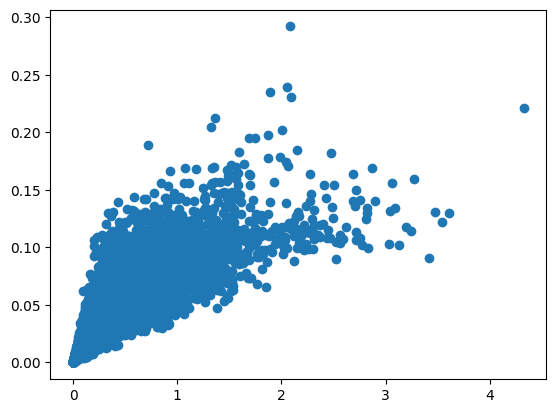

In [123]:
model='Addepalli2021Towards_RN18'
plt.scatter(unfilteredmodelscores[model]['feature dist'], unfilteredmodelscores[model]['input dist']);

<a id='errorbar'></a>  [top](#top1)

In [124]:
plot_markers = [
    ".",  # Point
    ",",  # Pixel
    "o",  # Circle
    "v",  # Downward-pointing triangle
    "^",  # Upward-pointing triangle
    "<",  # Left-pointing triangle
    ">",  # Right-pointing triangle
    "1",  # Filled downward-pointing triangle
    "2",  # Filled upward-pointing triangle
    "3",  # Filled left-pointing triangle
    "4",  # Filled right-pointing triangle
    "8",  # Octagon
    "s",  # Square
    "p",  # Pentagon
    "P",  # Filled pentagon
    "*",  # Star
    "h",  # Hexagon (variant 1)
    "H",  # Hexagon (variant 2)
    "+",  # Plus sign
    "x",  # Cross (variant 1)
    "X",  # Cross (variant 2)
    "D",  # Filled diamond
    "d",  # Diamond (thin outline)
    "|",  # Vertical line
    "_",  # Horizontal line
]
print(plot_markers)
# plot_markers = ['o', 's', 'D', '^', 'v', '+', 'x', 'H', '*', 'p', '8', 'P', 'h', '<', 'X', '#', 'y', '|', '1', 'd']
# plot_markers.remove('#')

['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_']


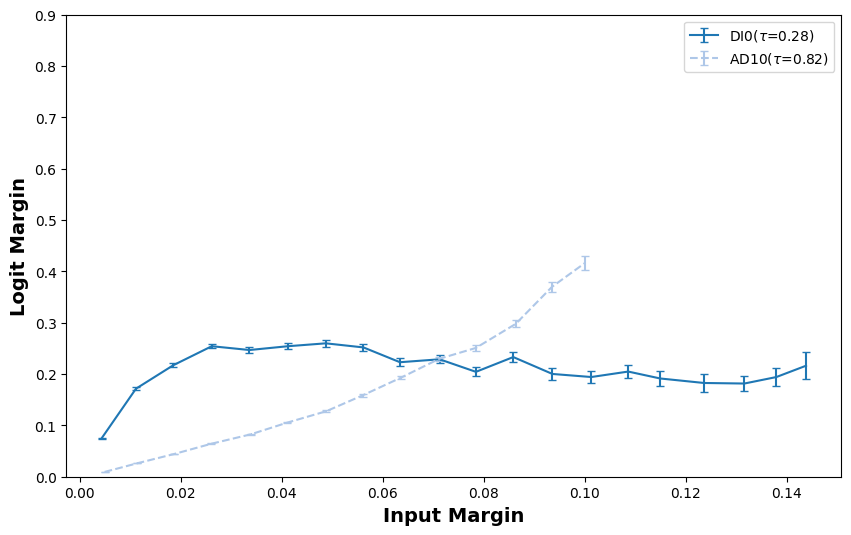

In [125]:
N = 20
N2=10
bin_edges = np.linspace(0, 0.15, N+1)
score='logit margin'

number_of_colors = 20
cmap = plt.get_cmap("tab20")
c = [cmap(i) for i in np.linspace(0, 1, number_of_colors)]
xmodels=[m for m in models if robust_accuracies[m]>1]
sortscore = [kdlcors[xmodels[i]][score] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
colors = dict()
linestyles =dict()
markers = dict()
ls = ['-', '--', '-.', ':']
# ls = random.choice(['-', '--', '-.', ':'])
# mrk=plot_markers[j]
for i, m in enumerate(xmodels):
    colors[m] = c[i]
    linestyles[m] = ls[i%len(ls)]
    markers[m] = plot_markers[i]
# xmodels=['madry_loss_r18_ckpt']
plt.figure(figsize=(10, 6))
for j, model in enumerate(xmodels[:]):
#     if model not in rbenchmodels:
#     if robust_accuracies[model]<1:
#         continue
#     if 'Ding' in model:
#         continue
    X= unfilteredmodelscores[model]['input dist']
    Y = unfilteredmodelscores[model][score]
    idxs, X =lq2(X)
    Y = Y[idxs]
    Y = (Y-Y.min())/(Y.max()-Y.min())
#     Y = Y/Y.max()
#     print(scipy.stats.kendalltau(X, Y)[0], model)
#     plt.subplot(2,1,1)
    mrk=plot_markers[j]
    plx(X, Y, M=N, label=getps(model, code=True).upper()+f"($\\tau$={kdlcors[model][score]:.2f})",
       shownumbers=False, color=colors[model], bin_edges=bin_edges, fmt=markers[m], ls=linestyles[model])
    # Set the x-axis labels to the bin ranges
#     bin_labels = [f"{bin_edges[i]:.2g} - {bin_edges[i+1]:.2g}" for i in range(N)]
#     plt.xticks(xmeans, bin_labels, rotation=45)
    # Set title and labels for the plot
#     print(f"cor:{cor:.2f} {model}")
#     sizes = [len(data) for data in data_to_plot]
#     for i in range(len(means)):
#         plt.annotate(f"{sizes[i]}", (xmeans[i], means[i]))
# plt.title()
plt.xlabel('Input Margin', fontsize=14, weight='bold')
plt.ylabel('Logit Margin', fontsize=14, weight='bold')
plt.ylim(0,0.9)
# plt.axvline(8/255, linestyle='--')
# Display the plot
plt.legend(loc='upper right', prop={"size": 10})
# plt.axis('equal')
# plt.xlim(0, 0.1)
# x = [i/255 for i in range(1, 40, 4)]
# xticks = [f"{i/255:.2f}" for i in range(1, 40, 4)]
# extraticks=[plt.Text(8/255, 0, "8/255")]
# plt.xticks(list(plt.xticks()[0]) + [8/255], list(plt.xticks()[1])+extraticks, rotation=75 )
# plt.xticks(x, xticks,rotation=75)
plt.savefig('figures/errorbar.pdf', bbox_inches='tight')
if False:
    ax= plt.gca()

    # Create a separate figure for the legend
    legend_fig = plt.figure()
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', ncol=2)
    plt.xticks([])
    plt.yticks([])
    # plt.subplot(2,1,2)
    # legend_fig.show()
    legend_fig.savefig('legend_errorbar.pdf')
plt.show()
plt.close()

### Dnet

In [126]:
def get_dbdata(model,epsilon=8/255):
    ##Train
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    y= torch.sqrt(y)
#     y = (y-y.min())/(y.max()-y.min())
    idxtr, idxts = train_test_split(np.arange(len(out)), test_size=0.2,
                                   random_state=0)
    X_train, y_train = out[idxtr], y[idxtr]
    X_test, y_test = out[idxts], y[idxts]

    return X_train, X_test, y_train, y_test, idxtr, idxts, y

In [127]:
def regcoreval(regr, X_test, y_test, model):
    y_score = regr.predict(X_test)
    cor = scipy.stats.kendalltau(y_test.ravel().numpy(), y_score.ravel().numpy())
    rmse = torch.sqrt(regr.loss_fn(y_test.view(-1,1), y_score.view(-1,1)))
    c = kdlcors[model]['logit margin']
    print(f"k. tau: {cor[0]:.2f}/{c:.2f}, rmse: {rmse:.2f}")

In [128]:
def get_data512(model,epsilon=8/255):
    ##Train
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    y= torch.sqrt(y)
    idxtr, idxts = train_test_split(np.arange(len(y)), test_size=0.2,
                                   random_state=0)
    X_train, y_train = out[idxtr], y[idxtr]
    X_test, y_test = out[idxts], y[idxts]
    ##
    return X_train, X_test, y_train, y_test, idxtr, idxts

<a id='dnet'>.</a>

In [129]:
Nclassifiers = dict()
xmodels =['Ding2020MMA']
splits=dict()
Nc=1
for model in tqdm(xmodels[:]):
    print(model)
    Nclassifiers[model]=[]
    X_train, X_test, y_train, y_test, idxtr, idxts =get_data512(model)
    splits[model]=(idxtr, idxts)
    for j in range(Nc):
#         splits[model].append((idxtr, idxts))
        regr = DeepNet(model=CNET(X_train.shape[1]),
                      loss_fn=torch.nn.MSELoss(),
                      verbose=False)
        tr_set = toDataset(X_train, y_train)
        regr.num_epochs = 500
        regr.batch_size= 5000
        regr.train(tr_set, seed=j*41)
        Nclassifiers[model].append(regr)
        regcoreval(regr, X_train, y_train, model)
        regcoreval(regr, X_test, y_test, model)
    print()

  0%|                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

Ding2020MMA


  0%|          | 0/500 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.54s/it]

k. tau: 0.68/0.28, rmse: 0.06
k. tau: 0.58/0.28, rmse: 0.07



In [130]:
regr.model

CNET(
  (arch): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [131]:
def test_perf(clf, X, y, z, split='Train', verbose=True):
    y_score = clf.predict(X)
    cor = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    corbefore = scipy.stats.kendalltau(y.ravel().numpy(), z.ravel().numpy())
    rmse = torch.sqrt(regr.loss_fn(y.view(-1,1), y_score.view(-1,1)))
    if verbose:
        print(f"{split}: {corbefore[0]:.2g} {cor[0]:.2g} {rmse:.3g}")
    return cor[0], corbefore[0], rmse

def get_list_perf(model, X, y, z, split, verbose):
    cors=[]
    corsb=[]
    rmses=[]
    for clf in  Nclassifiers[model]:
        cor, corb, rmse = test_perf(clf,X, y, z, split, verbose)
        cors.append(cor)
        corsb.append(corb)
        rmses.append(rmse)
    return np.array(corsb), np.array(cors), np.array(rmses)

for model in xmodels[:]:
    print(model)
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    y = torch.sqrt(y)
    idxtr, idxts = splits[model]
    Xtr, ytr = out[idxtr], y[idxtr]
#     torch.testing.assert_close(y, yo)
    Xval, yval = out[idxts], y[idxts]
    z = extraunfilteredscores[model]['logit margin']
    z = torch.Tensor(z)
    ztr, zval = z[idxtr], z[idxts]
    A, B, C = get_list_perf(model,Xtr, ytr, ztr, split='Train', verbose=False)
    print(f"Train: {A.mean():.2f}+/{A.std():.2f} \t {B.mean():.2f}+/-{B.std():.2f} \t {C.mean():.2f}+/-{C.std():.2f}")
    
    A, B, C = get_list_perf(model,Xval, yval, zval, split='Val', verbose=False)
    print(f"Val: {A.mean():.2f}+/-{A.std():.2f} \t {B.mean():.2f}+/-{B.std():.2f} \t {C.mean():.2f}+/-{C.std():.2f}")

    out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
    y = unfilteredmodelscores[model]['input dist']
    y = torch.Tensor(y)
    z = unfilteredmodelscores[model]['logit margin']
    z = torch.Tensor(z)
    A, B, C = get_list_perf(model,out, y, z, split='Test', verbose=False)
    print(f"Test: {A.mean():.2f}+/-{A.std():.2f} \t {B.mean():.2f}+/-{B.std():.2f} \t {C.mean():.2f}+/-{C.std():.2f}")
    print()

Ding2020MMA
Train: 0.31+/0.00 	 0.68+/-0.00 	 0.06+/-0.00
Val: 0.29+/-0.00 	 0.58+/-0.00 	 0.07+/-0.00
Test: 0.28+/-0.00 	 0.58+/-0.00 	 0.17+/-0.00



/Users/nj/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nj/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/jv/n0xvvy216hs8mqjb_t6j3s3h0000gn/T/ipykernel_59652/4097870659.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dts2 = pd.DataFrame({"train": torch.sqrt(torch.tensor(y))})
/Users/nj/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_

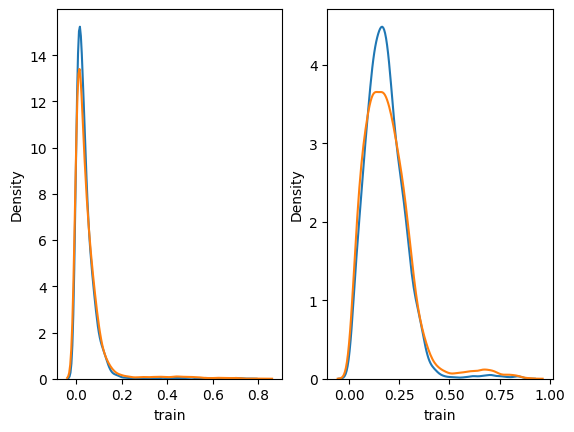

In [132]:
yx = extraunfilteredscores[model]['input dist']
dts = pd.DataFrame({"train": yx})
dts2 = pd.DataFrame({"train": y})
plt.subplot(1,2,1)
sns.kdeplot(data=dts, x="train");
sns.kdeplot(data=dts2, x="train");
dts = pd.DataFrame({"train": torch.sqrt(torch.tensor(yx))})
dts2 = pd.DataFrame({"train": torch.sqrt(torch.tensor(y))})
plt.subplot(1,2,2)
sns.kdeplot(data=dts, x="train");
sns.kdeplot(data=dts2, x="train");
# Show the plot
plt.show()

In [133]:
#Refill
for model in xmodels:
    regr = Nclassifiers[model][0]
    out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
    y = unfilteredmodelscores[model]['input dist']
    y = torch.tensor(y, dtype=torch.float32)
    y_score = regr.predict(out)
    cor10k = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    c10k = kdlcors[model]['logit margin']
    ##refill dnet scorfe
    unfilteredmodelscores[model]['dnet'] = y_score.ravel()
    kdlcors[model]['dnet'] = cor10k[0]

In [134]:
basescore='dnet'
for model in xmodels:
    regr = Nclassifiers[model][0]
    out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
    y = unfilteredmodelscores[model]['input dist']
    y = torch.tensor(y, dtype=torch.float32)
    y_score = regr.predict(out)
    cor10k = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    y = unfilteredmodelscores[model][basescore]
    c10k = kdlcors[model][basescore]
    
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    idxtr, idxts = train_test_split(np.arange(len(out)), test_size=0.2,
                                   random_state=0)
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    Xtr, ytr = out[idxtr], y[idxtr]
    Xval, yval = out[idxts], y[idxts]
    y = extraunfilteredscores[model][basescore]
    y = torch.Tensor(y)
    ztr, zval = y[idxtr], y[idxts]

    y_score = regr.predict(out)
    cor5k = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    c5k = extrakdlcors[model]['prob. margin']
    
    print(f"k. tau:5k:{cor5k[0]:.2f}/{c5k:.2f}   10k: {cor10k[0]:.2f}/{c10k:.2f} {model}")

k. tau:5k:-0.00/0.30   10k: 0.58/0.58 Ding2020MMA


In [135]:
def show_table(xmodels, scorename, kdcors, aucres):
    print(scorename)
    m=10
    l1 = [" "*m]
    # l1.extend(['corr.', 'auc','acc', 'rob.acc'])
    l1.extend(['K. tau', 'auroc', 'aupr', 'fpr@95', 'acc', 'rob.acc', 'arch'])
    print("\t".join(l1))
    sep="-"*60
    print(sep)
    dftex = pd.DataFrame(columns=["Model ID", 
                   "Kendall tau",
                   "AUROC",
                   "AUPR",
                   "FPR95",
                   "Acc", 
                   "Rob. Acc",
                    "Architecture"])   
    for model in xmodels:
#         if 'loss' in model:# or model in ['ResNet18', 'ResNet50']:
#             continue
        l2 = [getps(model)+" "*(m-len(getps(model)))]
        cor = f"{abs(kdcors[model][scorename]):0.2f}"
#         print(aucres['auroc'][model][scorename])
        auroc = f"{100*aucres['auroc'][model][scorename]:0.2f}"
        aupr = f"{100*aucres['aupr'][model][scorename]:0.2f}"
        fpr95 = f"{100*aucres['fprattpr'][model][scorename][0]:0.2f}"
        acc = clean_accuracies[model]
        rob_acc = robust_accuracies[model]
    #     l2.extend([cor, aucscore, str(acc), str(rob_acc)])
        l2.extend([cor, auroc, aupr, fpr95, str(acc), str(rob_acc), architectures[model]])
    #     print(l2)
        print("\t".join(l2))
        print(sep)
        new_row = {"Model ID":getps(model, code=True).upper(), 
                   "Kendall tau":cor,
                   "AUROC":auroc,
                   "AUPR":aupr,
                   "FPR95":fpr95,
                   "Acc":f"{acc:.2f}", 
                   "Rob. Acc":f"{rob_acc:.2f}",
                   "Architecture":architectures[model]
                  }
        dftex = pd.concat([dftex, pd.DataFrame([new_row])], ignore_index=True)
#         dftex.to_latex(escape=False)
    return dftex

In [137]:
xmodels =['Ding2020MMA']
scorename='dnet'
eps=8/255
nonrobust_flags = bin_separate(dfs, eps)
xrobres = get_AUCs(xmodels, nonrobust_flags,
                 xscores=unfilteredmodelscores, kdlcors=kdlcors)
show_table(xmodels, scorename, kdlcors, xrobres)

dnet
          	K. tau	auroc	aupr	fpr@95	acc	rob.acc	arch
------------------------------------------------------------
Ding2020MMA	0.58	89.64	90.20	48.22	84.36	41.44	WideResNet-28-4
------------------------------------------------------------


,Model ID,Kendall tau,AUROC,AUPR,FPR95,Acc,Rob. Acc,Architecture
0,DI0,0.58,89.64,90.20,48.22,84.36,41.44,WideResNet-28-4


0.31/\textbf{0.57} & 70.34/\textbf{88.49} & 74.07/\textbf{89.04}	& 81.60/\textbf{51.13}
0.51/\textbf{0.62} & 87.50]]/\textbf{93.66} & 71.46/\textbf{90.22}	&71.46/\textbf{33.00}

In [138]:
show_table(xmodels, basescore, kdlcors, xrobres)

dnet
          	K. tau	auroc	aupr	fpr@95	acc	rob.acc	arch
------------------------------------------------------------
Ding2020MMA	0.58	89.64	90.20	48.22	84.36	41.44	WideResNet-28-4
------------------------------------------------------------


,Model ID,Kendall tau,AUROC,AUPR,FPR95,Acc,Rob. Acc,Architecture
0,DI0,0.58,89.64,90.20,48.22,84.36,41.44,WideResNet-28-4


In [139]:
for model in xmodels:
    print(model)
    for s in ['logit margin', 'dnet']:
        print(xrobres['auroc'][model][s], xrobres['aupr'][model][s], xrobres['fprattpr'][model][s][0], s)
    print()

Ding2020MMA
0.674946377947852 0.7091395326954671 0.8256052523594584 logit margin
0.8964178812112845 0.9020319856753698 0.4821501846532622 dnet



Ding2020MMA


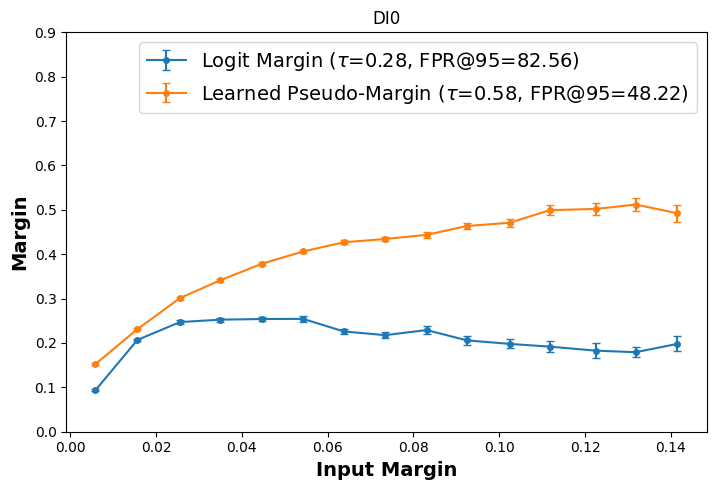

In [140]:
N = 15
N2=10
score='dnet'
basescore='logit margin'
# plt.subplots()
plt.figure(figsize=(14, 5))
counter=0
for model in xmodels[:]:
    counter=counter+1
    X= unfilteredmodelscores[model]['input dist']
    Y = unfilteredmodelscores[model][score]
    idxs, X =lq2(X)
    Y = Y[idxs]
    m, M=Y.min(), Y.max()
    Y = (Y-m)/(M-m)
    
    Z = unfilteredmodelscores[model][basescore]
    Z = Z[idxs]
    m, M=Z.min(), Z.max()
    Z = (Z-m)/(M-m)
#     print(counter)
    plt.subplot(1,2,counter)
    ridxs = random.sample(list(np.arange(len(X))), 1000)
#     plt.scatter(X[ridxs], Y[ridxs], s=1)
#     plt.scatter(X[ridxs], Z[ridxs], s=1)
    fpr950 = xrobres['fprattpr'][model]['logit margin'][0]*100
    fpr951 = xrobres['fprattpr'][model]['dnet'][0]*100
    plx(X, Z, M=N, label=f"Logit Margin ($\\tau$={kdlcors[model][basescore]:.2f}, FPR@95={fpr950:.2f})",
       shownumbers=False,ls=linestyles[model], fmt=markers[model])
    plx(X, Y, M=N, label=f"Learned Pseudo-Margin ($\\tau$={kdlcors[model][score]:.2f}, FPR@95={fpr951:.2f})",
           shownumbers=False, ls=linestyles[model], fmt=markers[model])
    plt.xlabel('Input Margin', fontsize=14, weight='bold')
    plt.ylabel('Margin', fontsize=14, weight='bold')
    print(model)
    if 'Xux' in model:
        plt.legend(bbox_to_anchor=(0.5, 0.5), prop={"size": 12})
    else:
        plt.legend(prop={"size": 14})
    plt.title(getps(model, code=True).upper())
    plt.ylim(0, 0.9)
# plt.axvline(8/255, linestyle='--')
# Display the plot
# plt.axis('equal')
# plt.legend()
# x = [i/255 for i in range(1, 40, 4)]
# xticks = [f"{i/255:.2f}" for i in range(1, 40, 4)]
# extraticks=[plt.Text(8/255, 0, "8/255")]
# plt.xticks(list(plt.xticks()[0]) + [8/255], list(plt.xticks()[1])+extraticks, rotation=75 )
# plt.xticks(x, xticks,rotation=75)
plt.tight_layout()
plt.savefig('figures/dnet_errorbar.pdf', bbox_inches='tight')
plt.show()
plt.close()

[Go to Epsvar](#epsvar)

### Plot Correlations

In [141]:
for model in [model for model in models if robust_accuracies[model]>1]:
    print(model, kdlcors[model]['max prob.'])

Addepalli2021Towards_RN18 0.7283066873115472
Ding2020MMA 0.2770099751884569


In [142]:
xscnames=['prob. margin',
 'logit margin',
 'max prob.',
 'output dist',
 'input dist']

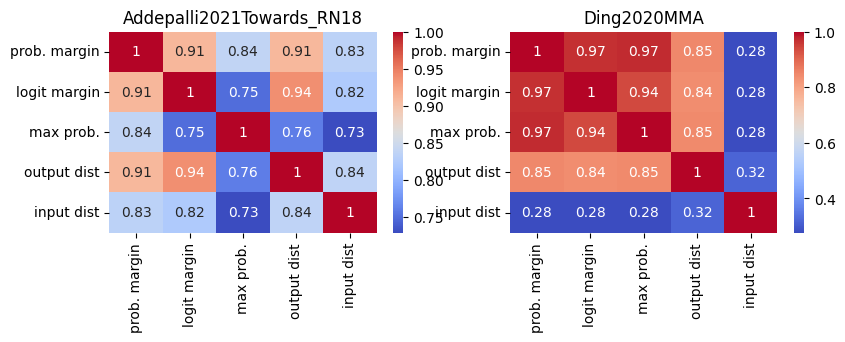

In [143]:
counter=0
plt.figure(figsize=(25,12))
for model in models:
    counter=counter+1
    M = np.zeros((len(xscnames), len(xscnames)))
    # for i in range(len(xscnames)):
    #     for j in range(len(xscnames)):
    for i, sc1 in enumerate(xscnames):
        for j, sc2 in enumerate(xscnames):
            score1 = unfilteredmodelscores[model][sc1]
            score2 = unfilteredmodelscores[model][sc2]
            cor = scipy.stats.kendalltau(score1, score2)[0]
            M[i, j] = abs(cor)
    # Create a heatmap with annotated values
    plt.subplot(4,5,counter)
    sns.heatmap(M, annot=True, fmt='.2g', cmap='coolwarm')

    xpseudos=xscnames
    x=np.arange(len(M))
    plt.xticks(x+1/2, xpseudos , rotation='vertical')
    plt.yticks(x+1/2, xpseudos , rotation='horizontal')

    # Show the plot
    plt.title(model)
plt.show()
#     plt.close()

In [144]:
# correct_predictions = get_correct_predictions(dfs)
eps=8/255
nonrobust_flags = bin_separate(dfs, eps)
xmodels = [model for model in models if robust_accuracies[model]>1]
robres = get_AUCs(xmodels, nonrobust_flags,
                 xscores=unfilteredmodelscores, kdlcors=kdlcors)
# robres['auroc'][model], robres['aupr'][model], robres['fprattpr'][model][1] 

<a id='cloud'></a>  [top](#top1)

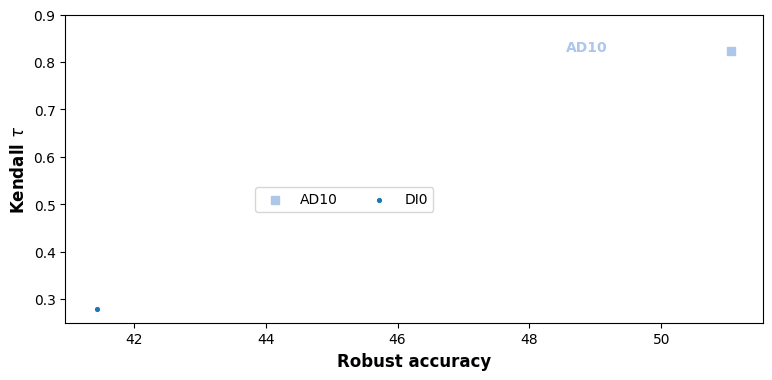

In [145]:
xmodels = models
# scorename='feature dist'
scorename='logit margin'
plt.figure(figsize=(9, 4))
for j in [scorename]:#range(len(scnames)):#
    cond = lambda x: robust_accuracies[x]>1 #and 'loss' not in x
    xmodels = [model for model in xmodels if cond(model)]
#     print(xmodels)
    scores = [abs(kdlcors[model][j]) for model in xmodels]
    rbaccs = [robust_accuracies[model] for model in xmodels]
#     lb1=getps(model, code=True, dataset='cifar10').upper()
    for k in range(len(rbaccs)):
        lb1=f"{getps(xmodels[k], code=True, dataset='cifar10').upper()}"
        plt.scatter(rbaccs[k], scores[k], label=lb1, color=colors[xmodels[k]], s=30, marker=markers[xmodels[k]]);
    plt.xlabel('Robust accuracy', fontsize=12, weight='bold');
    plt.ylabel("Kendall $\\tau$", fontsize=12, weight='bold');
    mylist = models #['Ding2020MMA']#, 'ResNet18', 'Debenedetti2022Light_XCiT-S12']
    for k, model in enumerate(xmodels):
        rbac, scor = robust_accuracies[model], abs(kdlcors[model][j])
        code=getps(model, code=True, dataset='cifar10').upper()
#         if code=='SE1':
#             plt.annotate(code, (rbac, scor),
#                         color=colors[model], weight='bold')
        if code in ['SE10', 'RE10']:
            plt.annotate(code, (rbac-2, scor-0.03),
                    color=colors[model], weight='bold')
        elif code=='WA80':
            plt.annotate(code, (rbac-2, scor+0.01),
                    color=colors[model], weight='bold')
        elif code=='CU80':
                plt.annotate(code, (rbac-0.8, scor-0.031),
                        color=colors[model], weight='bold')
        elif code=='RE80':
            plt.annotate(code, (rbac-2, scor-0.03),
                        color=colors[model], weight='bold')
        elif code=='HE0':
#             print(code)
            plt.annotate(code, (rbac, scor+0.01),
                        color=colors[model], weight='bold')
        elif code=='AD10':
            plt.annotate(code, (rbac-2.5, scor),
                        color=colors[model], weight='bold')
        elif code=='DS0':
#             print(code)
            plt.annotate(code, (rbac+0.5, scor+0.0),
                        color=colors[model], weight='bold')
        elif code=='DM0':
#             print(code)
            plt.annotate(code, (rbac+0.5, scor-0.01),
                        color=colors[model], weight='bold')
        else:
#             print(code)
            plt.annotate(code, (rbac-1, scor+0.015),
                        color=colors[model], weight='bold');
plt.legend(loc='center',ncol=3, bbox_to_anchor=(0.4, 0.4))
plt.ylim(0.25, 0.9)
plt.savefig('figures/cloudcorrel.pdf',  bbox_inches='tight');
plt.show()
plt.close()

In [146]:
print(scorename)
m=20
l1 = [" "*m]
l1.extend(['K. tau', 'before', 'acc', 'rob.acc',])
print("\t".join(l1))
sep="-"*65
print(sep)
# dftex = pd.DataFrame(columns=["Model ID", "Accuracy", "Robust Accuracy", "Kendall tau"])
sortscore = [kdlcors[xmodels[i]][j] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
##ECE, MCE
ece_mce = dict()
##
for model in xmodels:
    line = getps(model)
    l2 = [line+" "*(m-len(line))]
    jdnet=scorename
    ktau = abs(kdlcors[model][jdnet])
#     print(model, j, ktau)
#     break
    cor = f"{ktau:0.2f}"
    idm = 'dnet'
    cormaxp = f"{abs(kdlcors[model][idm]):0.2f}"
    acc = clean_accuracies[model]
    rob_acc = robust_accuracies[model]
    l2.extend([cor, cormaxp, str(acc), str(rob_acc)])
    if kdlcors[model][scorename]>0:
        print("\t".join(l2))
        print(sep)
#         new_row = {"Model ID":model, "Accuracy":acc, "Robust Accuracy":rob_acc, "Kendall tau":abs(float(cor))}
#         dftex = dftex.append(new_row, ignore_index=True)
#     #     dftex.to_latex(escape=False)

logit margin
                    	K. tau	before	acc	rob.acc
-----------------------------------------------------------------
Ding2020MMA         	0.28	0.58	84.36	41.44
-----------------------------------------------------------------
Addepalli2021       	0.82	0.00	80.24	51.06
-----------------------------------------------------------------


In [147]:
print('Kendall tau Correlations')
print()
l1 = [" "*4]
N = len(scnames)
l1.extend([scnames[i][:2] for i in range(N)])
# l1.extend(['acc', 'rob acc'])
print("\t".join(l1))
sep = "-"*80
print(sep)
dftex = pd.DataFrame(columns=["Model ID", "Accuracy", "Robust Accuracy"])
rbacs = [robust_accuracies[models[i]] for i in range(len(models))]
sortedargs =np.argsort(rbacs)
sortedargs = [i for i in sortedargs if robust_accuracies[models[i]]>1]
xmodels = [models[i] for i in sortedargs]
for i in sortedargs: 
    model= models[i]
    if 'loss' in model:# or model in ['ResNet18', 'ResNet50']:
        continue
    l2 = [pseudos[i][:5]+" "*(8-len(pseudos[i]))]
    l2.extend([f"{kdlcors[model][sc]:0.2f}" for sc in scnames])
#     acc = clean_accuracies[model]
#     rob_acc = robust_accuracies[model]
#     l2.extend([str(acc), str(rob_acc)])
    print("\t".join(l2))
    print(sep)
#     new_row = {"Model ID":pseudos[i], "Accuracy":acc, "Robust Accuracy":rob_acc}
#     for j in range(len(scnames)-1):
#         key = f"tau-{scnames[j]}"
#         new_row[key]= abs(float(kdlcors[model][j]))
#     dftex = dftex.append(new_row, ignore_index=True)

Kendall tau Correlations

    	pr	lo	ma	dn	fe	tc	tm	ou	in
--------------------------------------------------------------------------------
Ding2	0.28	0.28	0.28	0.58	0.57	0.29	0.28	0.32	1.00
--------------------------------------------------------------------------------
Addep	0.83	0.82	0.73	0.00	0.77	0.68	0.71	0.84	1.00
--------------------------------------------------------------------------------


## Binary Classification

In [148]:
def get_correct_predictions():
    y_binary = dict()
    for model in tqdm(models):
        outpath=fget_out_path(model)
        out = torch.load(outpath, map_location=torch.device('cpu'))
        cpd = out.max(1)[1] == ytargets[model]
        y_binary[model]= cpd.numpy()
    return y_binary
correct_predictions=get_correct_predictions()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 624.38it/s]


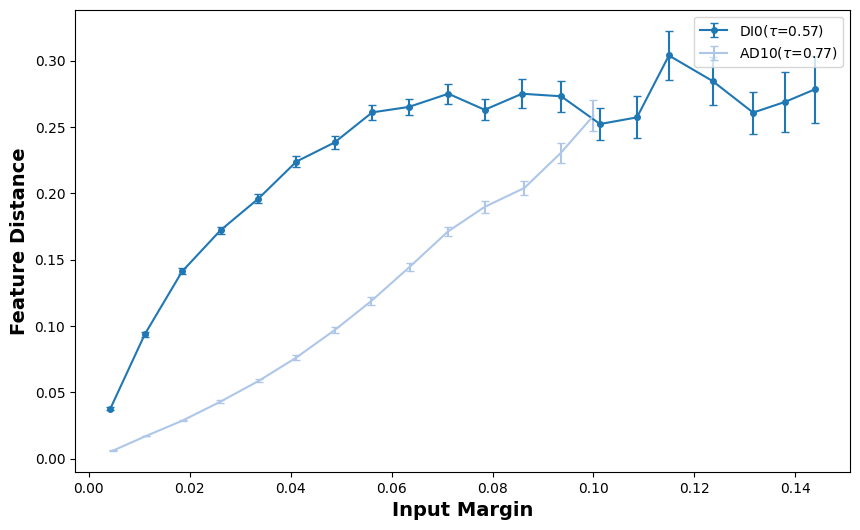

In [149]:
N = 20
N2=10
bin_edges = np.linspace(0, 0.15, N+1)
score='feature dist'
xmodels=[m for m in models if robust_accuracies[m]>1]
sortscore = [kdlcors[xmodels[i]][score] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
colors = dict()
for i, m in enumerate(xmodels):
    colors[m] = c[i]
# xmodels=['madry_loss_r18_ckpt']
plt.figure(figsize=(10, 6))
for j, model in enumerate(xmodels[:]):
    X= unfilteredmodelscores[model]['input dist']
    Y = unfilteredmodelscores[model][score]
    idxs, X =lq2(X)
    Y = Y[idxs]
    Y = (Y-Y.min())/(Y.max()-Y.min())
#     Y = Y/Y.max()
#     print(scipy.stats.kendalltau(X, Y)[0], model)
#     plt.subplot(2,1,1)
    plx(X, Y, M=N, label=getps(model, code=True, dataset='cifar10').upper()+f"($\\tau$={kdlcors[model][score]:.2f})",
       shownumbers=False, color=colors[model], bin_edges=bin_edges, fmt=markers[model])
# plt.title()
plt.xlabel("Input Margin", fontsize=14, weight='bold')
plt.ylabel("Feature Distance", fontsize=14, weight='bold')
# plt.axvline(8/255, linestyle='--')
# Display the plot
plt.legend(loc='upper right')#, prop={"size":11})
plt.savefig('figures/featerrorbar.pdf', bbox_inches='tight')
plt.show()
plt.close()

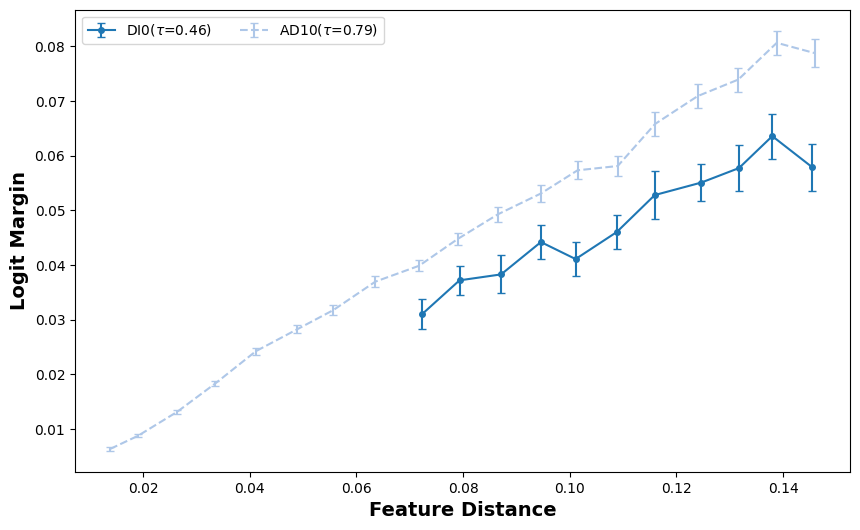

In [150]:
N = 20
N2=10
bin_edges = np.linspace(0, 0.15, N+1)
xmodels=[m for m in models if robust_accuracies[m]>1]
sortscore = [kdlcors[xmodels[i]][score] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
colors = dict()
for i, m in enumerate(xmodels):
    colors[m] = c[i]
plt.figure(figsize=(10, 6))
for j, model in enumerate(xmodels[:]):
    X = unfilteredmodelscores[model]['feature dist']
    Y = unfilteredmodelscores[model]['logit margin']
    cor = scipy.stats.kendalltau(X, Y)[0]
    idxs, X =lq2(X)
    Y = Y[idxs]
    Y = (Y-Y.min())/(Y.max()-Y.min())
    plx(X, Y, M=N, label=getps(model, code=True).upper()+f"($\\tau$={cor:.2f})",
       shownumbers=False, color=colors[model], 
        bin_edges=bin_edges, fmt=markers[model], ls=linestyles[model])
plt.ylabel("Logit Margin", fontsize=14, weight='bold')
plt.xlabel("Feature Distance", fontsize=14, weight='bold')
plt.legend(loc='upper left', prop={"size": 10}, ncol=3)
plt.savefig('figures/featvslogit.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Sanity Check

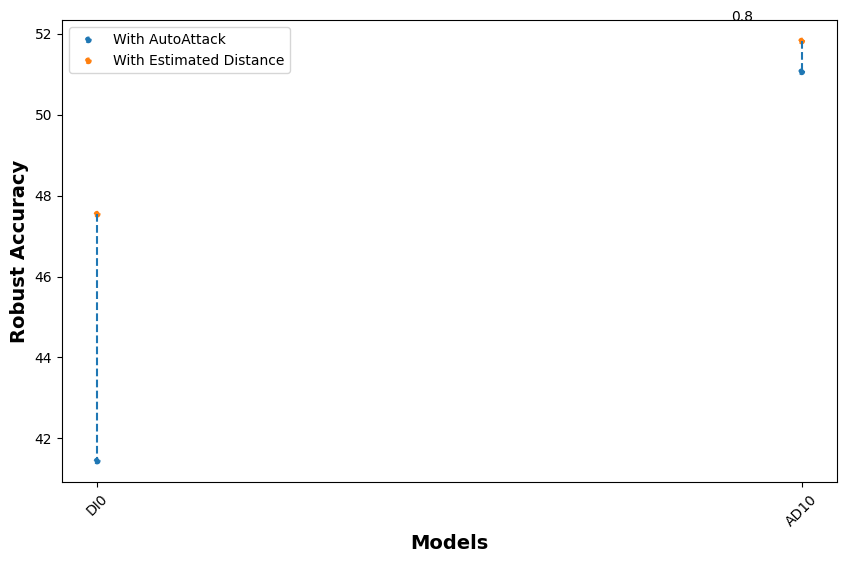

In [151]:
epsilon=8/255
robestimations=dict()
xmodels=models
plt.figure(figsize=(10, 6))
for model in xmodels:
    margins=unfilteredmodelscores[model]['input dist']
    out = torch.load(fget_out_path(model,dataset='cifar10'), map_location='cpu')
    correct_pred = out.max(1)[1].eq(ytargets[model])
    vulnerable = margins <= epsilon
    RobAcc = 100*(correct_pred & ~vulnerable).float().mean()
    robestimations[model] = RobAcc

rbaccs = np.array([robust_accuracies[m] for m in xmodels])
sortedx = np.argsort(rbaccs)
rbaccs=rbaccs[sortedx]
xmodels=[xmodels[i] for i in sortedx]
estimrbaccs=np.array([robestimations[m] for m in xmodels])
plt.scatter(np.arange(len(xmodels)),rbaccs, linestyle='--', label='With AutoAttack', s=15);
plt.scatter(np.arange(len(xmodels)),estimrbaccs, linestyle='--', label='With Estimated Distance', s=15);
for j, model in enumerate(xmodels):
    plt.vlines(j,robestimations[model], robust_accuracies[model], linestyle='--');
    ecart=abs(robestimations[model]-robust_accuracies[model])
#     if j%2 == 0:
#         point = max([robestimations[model].mean(), robust_accuracies[model]])+0.5
#     else:
#         point = min([robestimations[model].mean(), robust_accuracies[model]])-1.3
    point = max([robestimations[model].mean(), robust_accuracies[model]])+0.5
#     point = (robestimations[model].mean() + robust_accuracies[model])/2
#     plt.annotate(f"{ecart.mean():.1f}+/-{ecart.std():.0f}",(j-0.5, point))
    plt.annotate(f"{ecart.mean():.1f}",(j-0.1, point))
    plt.xticks(np.arange(len(sortedx)), [get_code(m) for m in xmodels], rotation=45);
plt.legend();
plt.xlabel('Models', fontsize=14, weight='bold')
plt.ylabel('Robust Accuracy', fontsize=14, weight='bold')
plt.savefig('sanitycheck.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [152]:
ecarts = np.array([abs(robestimations[m]-robust_accuracies[m]) for m in models])
ecarts.mean(), ecarts.max()

(3.4300003, 6.1000023)

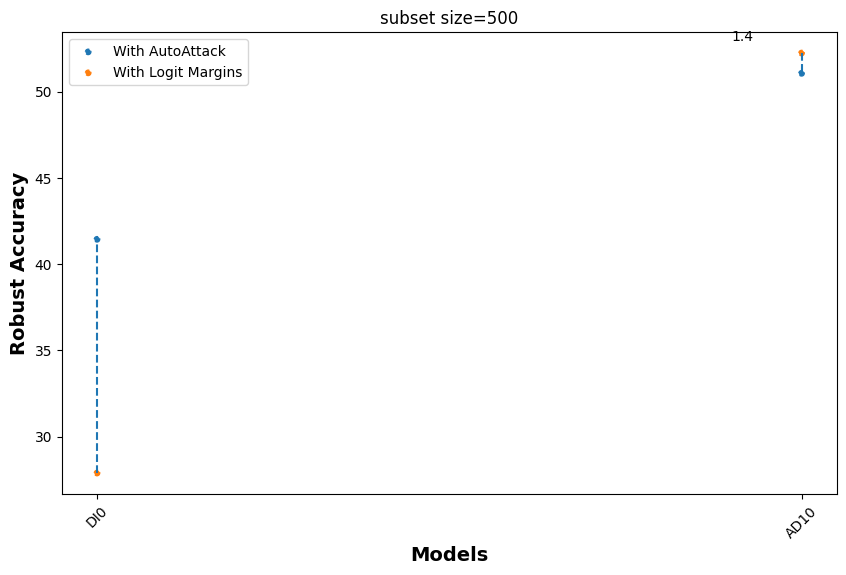

In [153]:
xmodels = [m for m in models if kdlcors[m]['logit margin']>0.]
plt.figure(figsize=(10, 6))
for n_subset in [500]:
    robestimations = dict()
    corestimations = dict()
    for j, model in enumerate(xmodels):
        margins=unfilteredmodelscores[model]['input dist'] 
        out = torch.load(fget_out_path(model,dataset='cifar10'), map_location='cpu')
        robestims=[]
        corestims=[]
        for k in range(10):
            robestim, cor = SampleEfficientRobustAccuracy(margins, logits=out,
                                              labels=ytargets[model],
                                              epsilon=8/255,
                                              n_subset=n_subset)
            robestims.append(robestim)
            corestims.append(cor)
        robestims=np.array(robestims)
        corestims=np.array(corestims)
        robestimations[model]=robestims
        corestimations[model]=corestims
    ####
    ####
    rbaccs = np.array([robust_accuracies[m] for m in xmodels])
    sortedx = np.argsort(rbaccs)
    rbaccs=rbaccs[sortedx]
    xmodels=[xmodels[i] for i in sortedx]
    estimrbaccs=np.array([robestimations[m].mean() for m in xmodels])
    plt.scatter(np.arange(len(xmodels)),rbaccs, linestyle='--', label='With AutoAttack', s=15);
    plt.scatter(np.arange(len(xmodels)),estimrbaccs, linestyle='--', label='With Logit Margins', s=15);
    for j, model in enumerate(xmodels):
        plt.vlines(j,robestimations[model].mean(), robust_accuracies[model], linestyle='--');
        ecart=abs(robestimations[model]-robust_accuracies[model])
    #     std = abs(robestimations[model]-robust_accuracies[model]).std()
#         if j%2 == 0:
#             point = max([robestimations[model].mean(), robust_accuracies[model]])+0.7
#         else:
#             point = min([robestimations[model].mean(), robust_accuracies[model]])-2
        point = max([robestimations[model].mean(), robust_accuracies[model]])+0.7
    #     point = (robestimations[model].mean() + robust_accuracies[model])/2
    #     plt.annotate(f"{ecart.mean():.1f}+/-{ecart.std():.0f}",(j-0.5, point))
        plt.annotate(f"{ecart.mean():.1f}",(j-0.1, point))
        plt.xticks(np.arange(len(sortedx)), [get_code(m) for m in xmodels], rotation=45);
    plt.legend();
    plt.title(f"subset size={n_subset}")
    plt.xlabel('Models', fontsize=14, weight='bold')
    plt.ylabel('Robust Accuracy', fontsize=14, weight='bold')
    if n_subset==500:
        plt.savefig('figures/robustestim.pdf', bbox_inches='tight')
#     print(scipy.stats.kendalltau(rbaccs, estimrbaccs)[0])
    plt.show()
    plt.close()

In [154]:
##### xmodels = [m for m in models if kdlcors[m]['logit margin']>0.5]
robestimations = dict()
corestimations = dict()
for model in xmodels:
    robestimations[model]=[]
    corestimations[model]=[]
varsubset = [50, 100, 200, 300, 500, 1000, 5000]
for n_subset in tqdm(varsubset):
    for j, model in enumerate(xmodels):
#         if getps(model, code=True, dataset='cifar10')!='AD20':
#             continue
        margins=unfilteredmodelscores[model]['input dist'] 
        out = torch.load(fget_out_path(model,dataset='cifar10'), map_location='cpu')
        robestims=[]
        corestims=[]
        for k in range(10):
            robestim, cor = SampleEfficientRobustAccuracy(margins, logits=out,
                                              labels=ytargets[model],
                                              epsilon=8/255,
                                              n_subset=n_subset)
            robestims.append(robestim)
            corestims.append(cor)
        robestims=np.array(robestims)
        corestims=np.array(corestims)
        robestimations[model].append(robestims)
        corestimations[model].append(corestims)
    ####
####

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.88it/s]


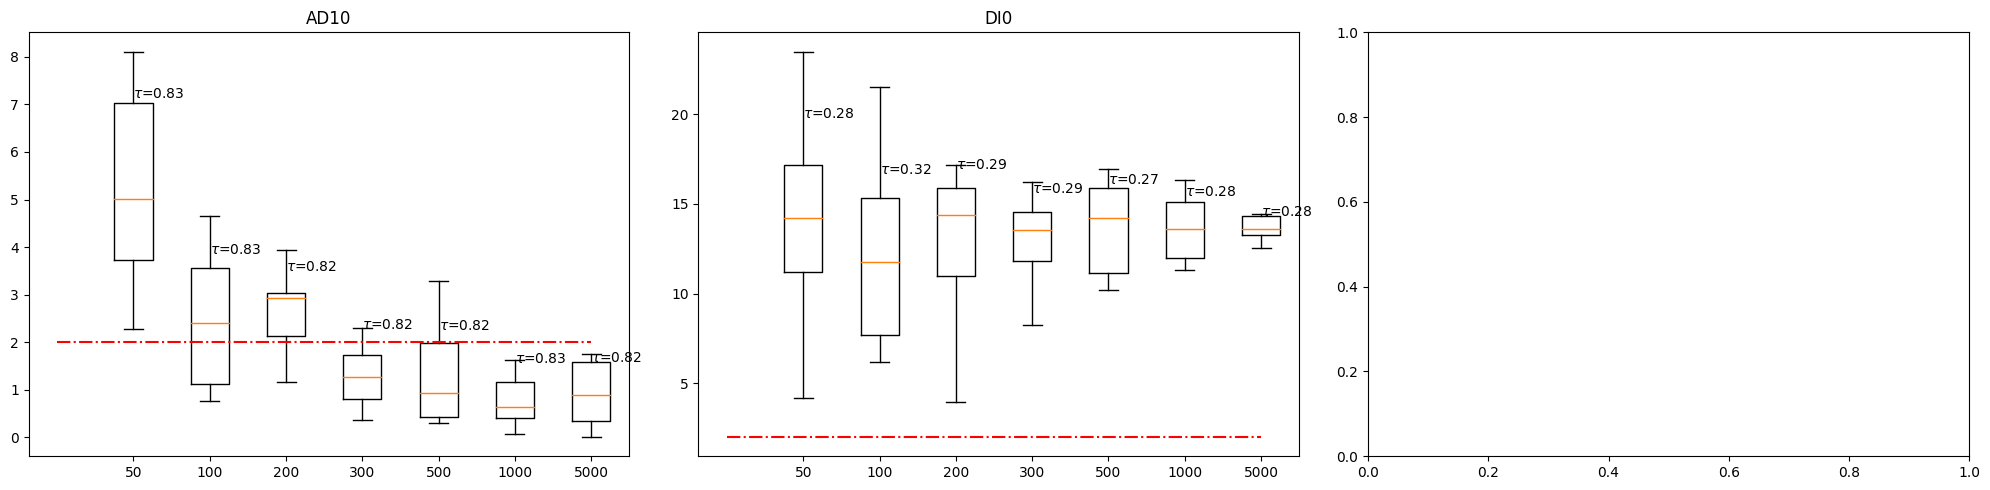

In [155]:
num_rows, num_cols = 1, 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, model in enumerate(models):
    col = i % num_cols
    ecarts = [abs(robestimations[model][i] - robust_accuracies[model]) for i in range(len(varsubset))]
    axs[col].boxplot(ecarts, showfliers=False)
    axs[col].set_xticks(np.arange(1, len(varsubset) + 1), varsubset, rotation=0)
    axs[col].set_title(getps(model, code=True, dataset='cifar10'))
    for j, n_subset in enumerate(varsubset):
        cor = corestimations[model][j].mean()
        j2 = ecarts[j].mean() + ecarts[j].std()
        axs[col].annotate(f"$\\tau$={cor:.2f}", (j + 1, j2))
    axs[col].hlines(2, 0, len(varsubset), linestyle='-.', color='red')
plt.tight_layout()
plt.savefig('figures/varsampleefficiency.pdf', bbox_inches='tight')
plt.show()

In [156]:
# correct_predictions = get_correct_predictions(dfs)
eps=8/255
nonrobust_flags = bin_separate(dfs, eps)
xmodels = [model for model in models if robust_accuracies[model]>1]
robres = get_AUCs(xmodels, nonrobust_flags,
                 xscores=unfilteredmodelscores, kdlcors=kdlcors)
# robres['auroc'][model], robres['aupr'][model], robres['fprattpr'][model][1] 

In [157]:
lim=0
scorename='logit margin'
rbacs = [robust_accuracies[models[i]] for i in range(len(models))]
#     lim = 1#-1 if misD else 1
sortedargs = np.argsort([kdlcors[models[i]][scorename] for i in range(len(models))])
#     sortedargs = np.argsort([robust_accuracies[model] for model in models])
xmodels = [models[i] for i in sortedargs if robust_accuracies[models[i]]>lim]
# scorename='dnet'
dftex = show_table(xmodels, scorename, kdlcors, robres)
dftex.to_latex(escape=False)

logit margin
          	K. tau	auroc	aupr	fpr@95	acc	rob.acc	arch
------------------------------------------------------------
Ding2020MMA	0.28	67.49	70.91	82.56	84.36	41.44	WideResNet-28-4
------------------------------------------------------------
Addepalli2021	0.82	97.86	97.68	13.26	80.24	51.06	ResNet-18
------------------------------------------------------------


'\\begin{tabular}{lllllllll}\n\\toprule\n & Model ID & Kendall tau & AUROC & AUPR & FPR95 & Acc & Rob. Acc & Architecture \\\\\n\\midrule\n0 & DI0 & 0.28 & 67.49 & 70.91 & 82.56 & 84.36 & 41.44 & WideResNet-28-4 \\\\\n1 & AD10 & 0.82 & 97.86 & 97.68 & 13.26 & 80.24 & 51.06 & ResNet-18 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [158]:
for model in xmodels:
    if robust_accuracies[model]<1:
        continue
    print(getps(model, code=True).upper(), model)

DI0 Ding2020MMA
AD10 Addepalli2021Towards_RN18


<a id='rocvar1'></a>  [top](#top1)

In [159]:
def get_ratio(binvalues):
    y_onehot_full = np.array(binvalues).astype(int)
    negatives = (y_onehot_full==0).sum()
    positives = len(y_onehot_full)-negatives
    ratio = negatives/(positives+negatives)
#     assert negatives!=0 and positives!=0
    return ratio

In [160]:
def fillaucscores(model, epsilons=None):
    aurocmodels[model] = []
    auprmodels[model] = []
    ratiomodels[model] = []
    fpr95models[model] = []
    fprtprvalues[model] = []
    precrecvalues[model]=[]
    xepsilons = []
    for epsilon in tqdm(epsilons):
    #     print(epsilon)
        xnonrobust_flags = bin_separate(dfs, epsilon)
        binvalues  = xnonrobust_flags[model]
        r = get_ratio(binvalues)
        if r<0.001 or r>0.999:
            continue
        xepsilons.append(epsilon)
        scores = unfilteredmodelscores[model]['logit margin']
        xres = xget_AUCs(binvalues, -scores)
        aurocmodels[model].append(xres['auroc'])
        auprmodels[model].append(xres['aupr'])
        ratiomodels[model].append(xres['ratio'])
        fpr95models[model].append(xres['fprattpr'])
        fprtprvalues[model].append(xres['fpr_tpr'])
        precrecvalues[model].append(xres['prec_rec'])
    return xepsilons

<a id='epsvar'>.</a>  [Back to Dnet](#dnet)

<a id='rocvar2'></a>  [top](#top1)

In [161]:
eps=8/255

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 125.94it/s]


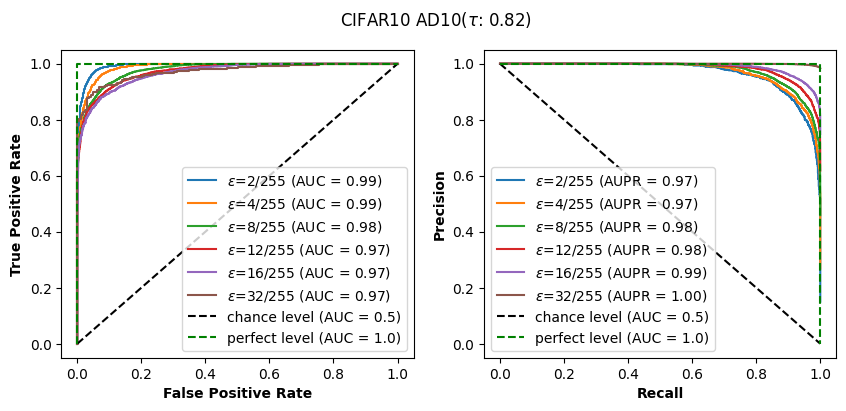

In [162]:
def xplot_roc(label, fpr, tpr):
    auroc = calc_auc(fpr, tpr)
    plt.plot(fpr,tpr, label=label+f" (AUC = {auroc:.2f})")
    return auroc
def plot_varroc(xepsilons, model, aurocs, fprtprvalues):
    for k, epsilon in enumerate(xepsilons):
        fpr, tpr = fprtprvalues[model][k]
        auroc = xplot_roc(labels[k], fpr, tpr)
        aurocs[k]=auroc
###########
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 0, 1], [0, 1, 1], "g--", label="perfect level (AUC = 1.0)")
    plt.xlabel("False Positive Rate", fontsize=10, weight='bold')
    plt.ylabel("True Positive Rate", fontsize=10, weight='bold')
    plt.legend()
    fig = plt.gcf()
#     fig.set_size_inches(7, 6)

def xplot_pr(label, pr, rc):
    aupr = calc_auc(rc, pr)
    plt.plot(rc,pr, label=label+f" (AUPR = {aupr:.2f})")
    return aupr
def plot_prvar(xepsilons, model, auprs, precrecvalues):
    for k, epsilon in enumerate(xepsilons):
        pr, rc = precrecvalues[model][k]
        aupr = xplot_pr(labels[k], pr, rc)
        auprs[k]=aupr
###########
    plt.plot([0, 1], [1, 0], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 1, 1], [1, 1, 0], "g--", label="perfect level (AUC = 1.0)")
    plt.xlabel("Recall", fontsize=10, weight='bold')
    plt.ylabel("Precision", fontsize=10, weight='bold')
    plt.legend()
    fig = plt.gcf()
    
aurocmodels=dict()
auprmodels=dict()
ratiomodels=dict()
fpr95models=dict()
fprtprvalues = dict()
precrecvalues=dict()
epsilons = [2/255, 4/255, 8/255, 12/255, 16/255, 32/255]
labels = [f"2/255", "4/255", "8/255", "12/255", "16/255", "32/255"]
labels = [f"$\\epsilon$="+e for e in labels]
jmp='logit margin'
# xmodels = [model for model in models if kdlcors[model][jmp]>.7]
xmodels=['Addepalli2021Towards_RN18']
counter=0
for model in xmodels:
#     plt.figure(figsize=(10, 4))
    xepsilons = fillaucscores(model, epsilons)
#     print(xepsilons)
#     plt.figure(figsize=(8,7))
    aurocs = np.zeros_like(xepsilons)
    auprs = np.zeros_like(xepsilons)
#     print(counter, counter+1)
    plt.subplot(1,2,1)
    plot_varroc(xepsilons, model, aurocs, fprtprvalues)
    plt.suptitle("CIFAR10 "+getps(model, code=True).upper()+f"($\\tau$: {kdlcors[model][jmp]:.2f})")
    plt.subplot(1,2,2)
    plot_prvar(xepsilons, model, auprs, precrecvalues)
#     plt.title("CIFAR10 "+getps(model, code=True).upper()+f"($\\tau$: {kdlcors[model][jmp]:.2f})")
    counter+=1
    fig = plt.gcf()
    fig.set_size_inches(10, 4)
######    
    plt.savefig(f"figures/rocvariationc_{counter}.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

[top](#epsvar)